In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import glob
import time

import numpy as np
# import seaborn as sns

from sklearn.metrics import adjusted_rand_score

In [26]:
def load_clusterings(fpath):
    levels = []
    with open(fpath, 'r') as f:
        it = iter(f)
        while True:
            try:
                line = next(it)
                if line.startswith('# Level'):
                    n = int(next(it).strip())
                    levels.append(np.zeros((n,), dtype=np.int32))
                    i = 0
                else:
                    levels[-1][i] = int(line.strip())
                    i += 1
            except StopIteration:
                break
    return levels

def score_clustering(clusts, gtruth):
    c = np.copy(clusts[0])
    g = np.copy(gtruth[0])
    scores = [adjusted_rand_score(c, g)]
    
    for l in range(1, min(len(clusts), len(gtruth))):
        # Translate each to the next level
        map_c = {low:hi for low,hi in enumerate(clusts[l])}
        map_g = {low:hi for low,hi in enumerate(gtruth[l])}
        for i in xrange(c.shape[0]):
            c[i] = map_c[c[i]]
            g[i] = map_g[g[i]]
        scores.append(adjusted_rand_score(c, g))
    return scores

def score_clustering_best_match(clusts, gtruth):
    c = np.copy(clusts[0])
    g = np.copy(gtruth[0])
    scores = []
    
    def maybe_remap(it, c, all_c):
        if it == 0:
            return
        map_ = {low:hi for low,hi in enumerate(all_c[it])}
        for i in xrange(c.shape[0]):
            c[i] = map_[c[i]]
    
    for li in range(len(gtruth)):
        lvl_scores = []
        c = np.copy(clusts[0])
        maybe_remap(li, g, gtruth)
        
        for lj in range(len(clusts)):
            maybe_remap(lj, c, clusts)
            lvl_scores.append(adjusted_rand_score(c, g))
        if li == len(gtruth) - 1:
            assert np.sum(g == g[0]) == g.shape[0]
            scores.append(1.0)
        else:
            scores.append(max(lvl_scores))
    return scores

def get_peak_modularity(log_fpath):
    with open(log_fpath, 'r') as f:
        for line in f:
            pass
    return float(line.split()[-1])

In [33]:
graphs = glob.glob('../beyond/exp2/*.bin')
gtruths = glob.glob('../beyond/exp2/*.labels')
logs = glob.glob('../beyond/exp2/*.log')
clusts = glob.glob('../beyond/exp2/*.clusts')

files = {g: {} for g in graphs}
for t in gtruths:
    key = [g for g in graphs if g in t][0]
    files[key]['gtruth'] = t
for l in logs:
    key = [g for g in graphs if g in l][0]
    files[key]['log'] = l
for c in clusts:
    key = [g for g in graphs if g in c][0]
    files[key]['clusts'] = c

In [34]:
# Key: Experiments
# ================
# - g0 denotes graphs sampled from a perfect binary tree
#    - c=XXX is leaf cluster size
#    - p=XXX is leaf cluster edge probability
#    - d=XXX denotes pbb decay when going up the tree (default d=2.0 halves the probability)
#    - h=XXX is the tree height
# - g1 denotes https://github.com/Napech/HedonisticHierarchy/blob/master/figures/Lowerbound_hierarchy1.pdf
# - g2 denotes https://github.com/Napech/HedonisticHierarchy/blob/master/figures/Lowerbound_hierarchy2.pdf
#    - c=XXX is leaf cluster size
#    - p=XXX is leaf cluster edge probability
#
# Key: Algorithms
# ===============
# - Louvain
#     - \rho
# - Hedonistic
#     - hsqrt -- use f(x) = sqrt(x) in the denominator instead of f(x) = x
#     - noloops -- do not count A_{ii} (self-loops) in the numerator

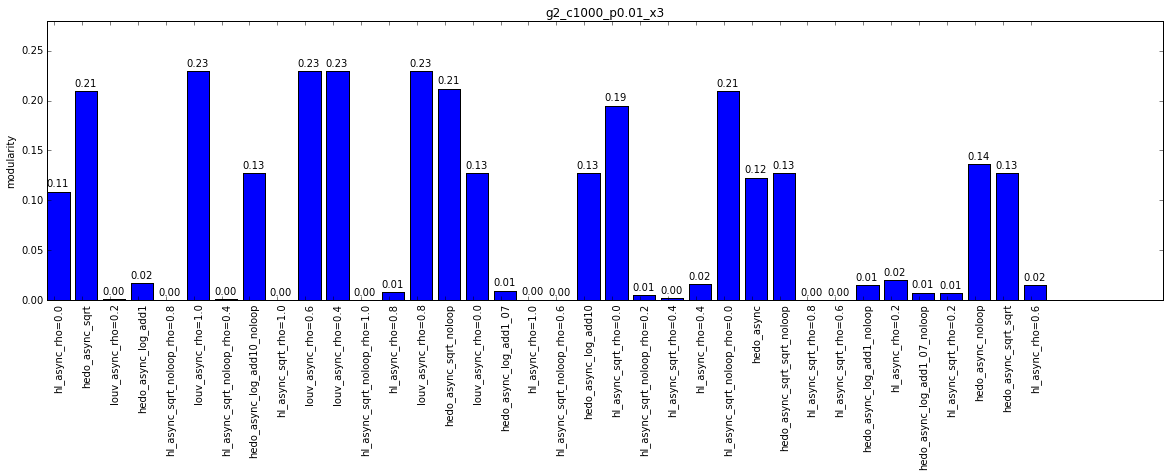

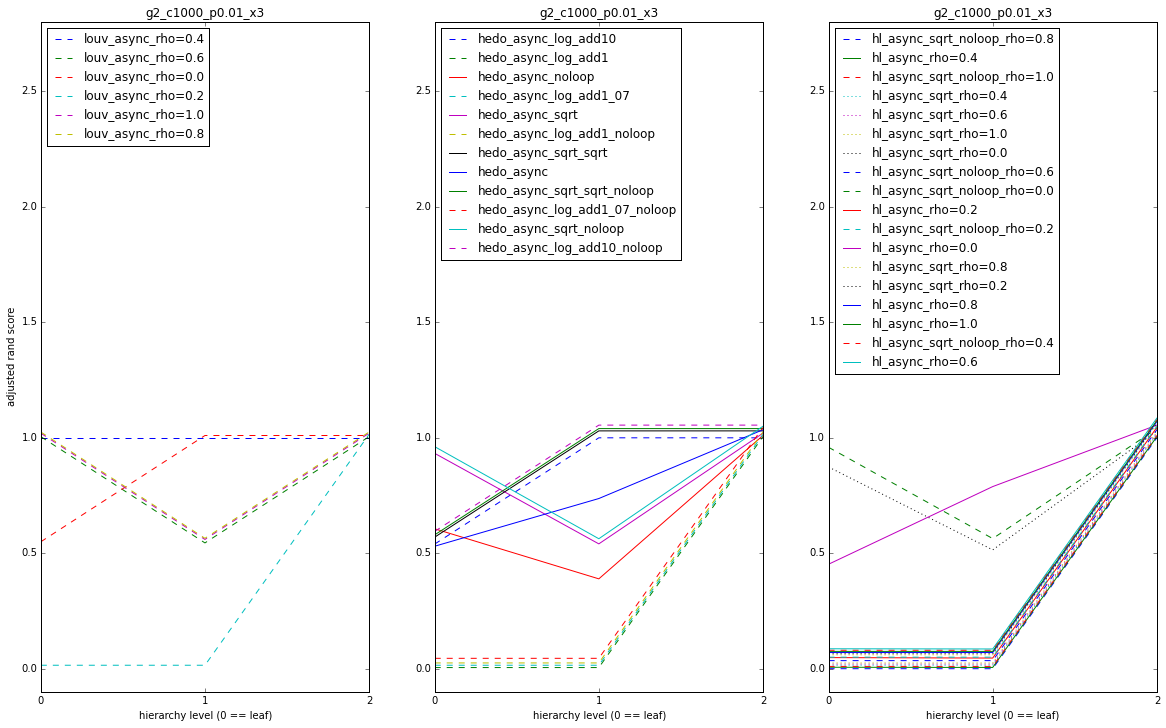

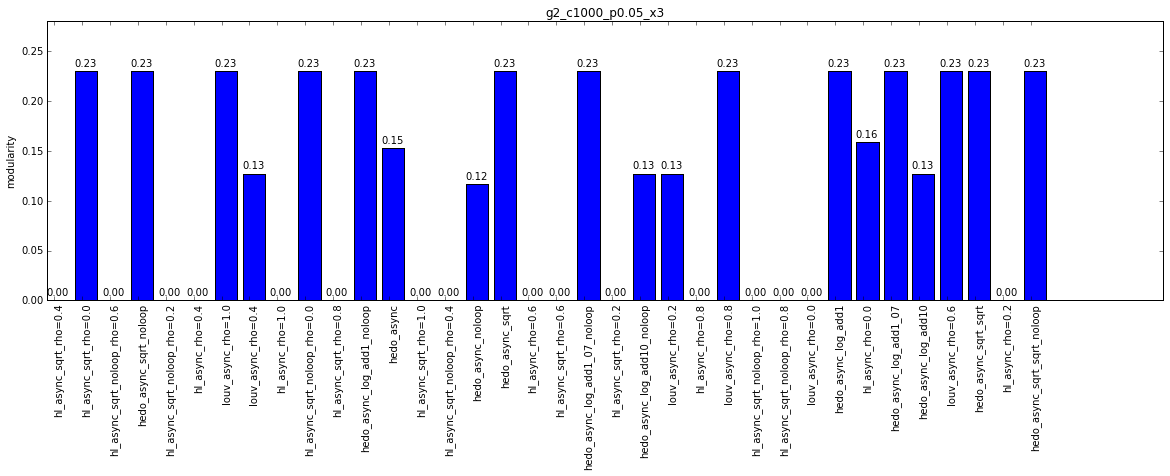

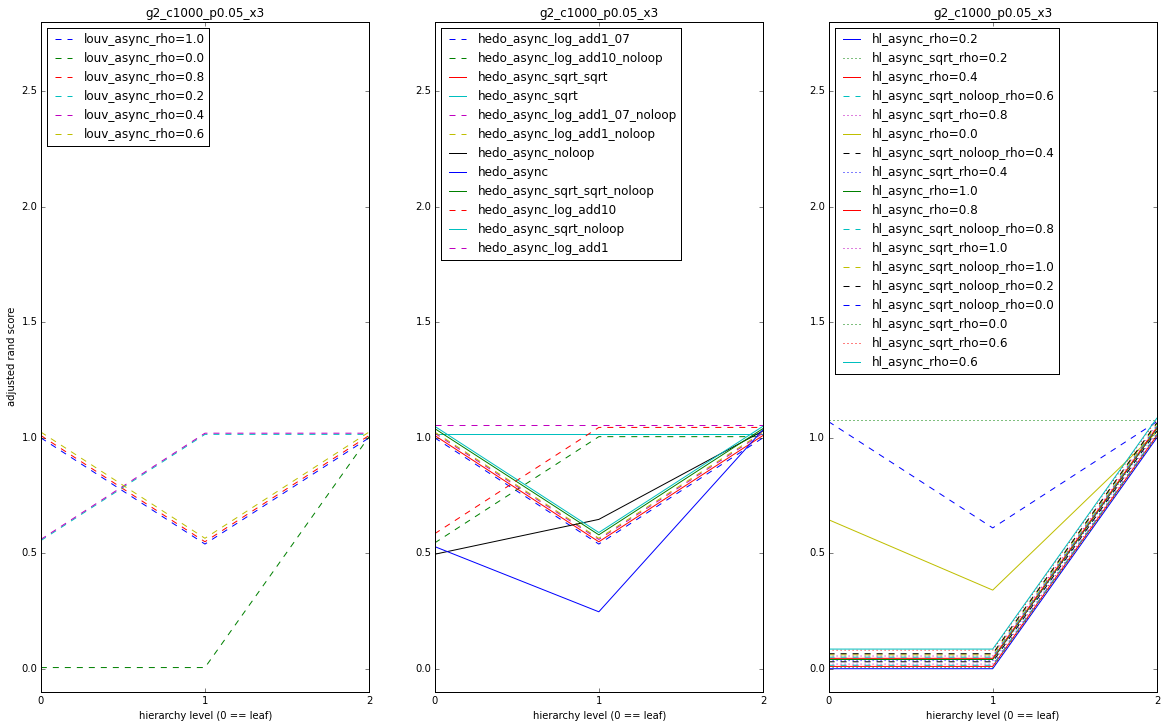

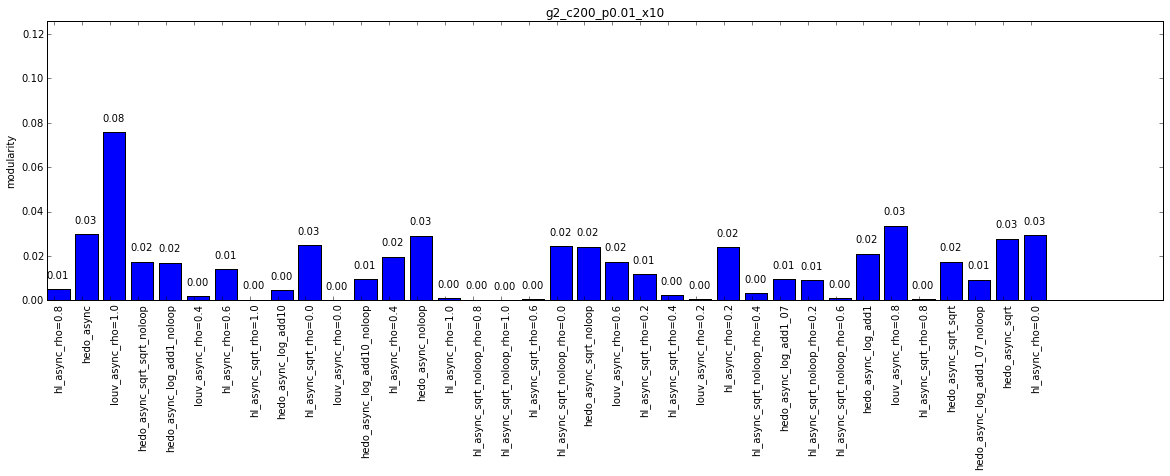

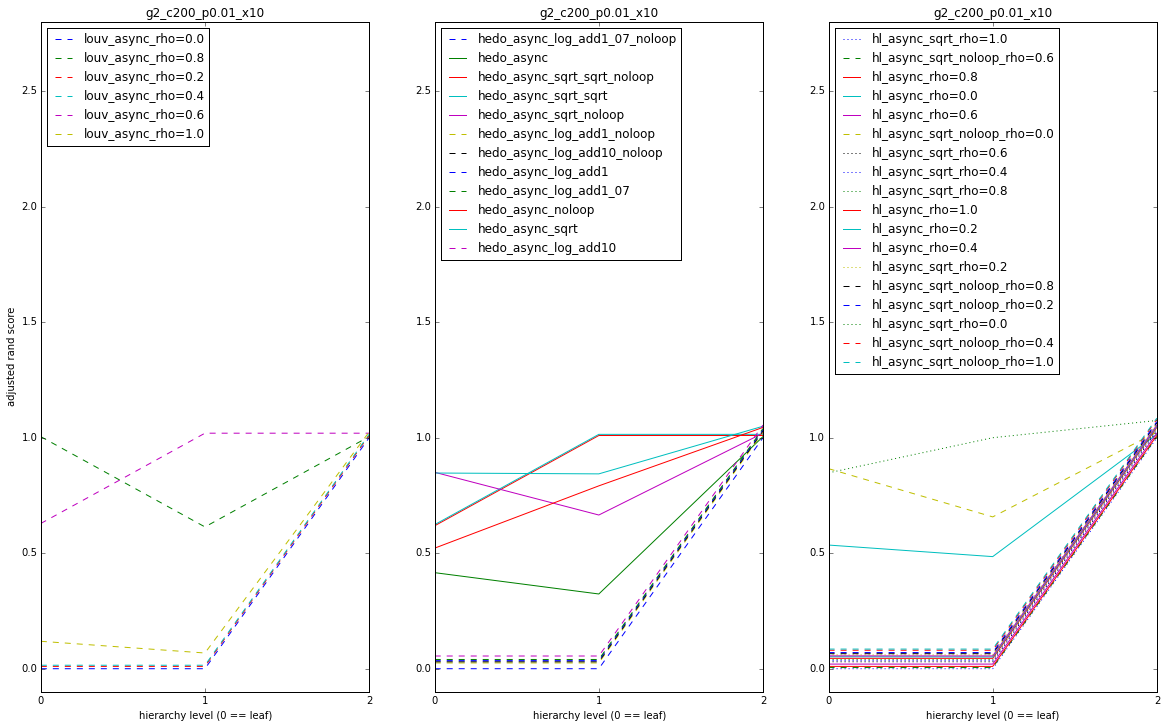

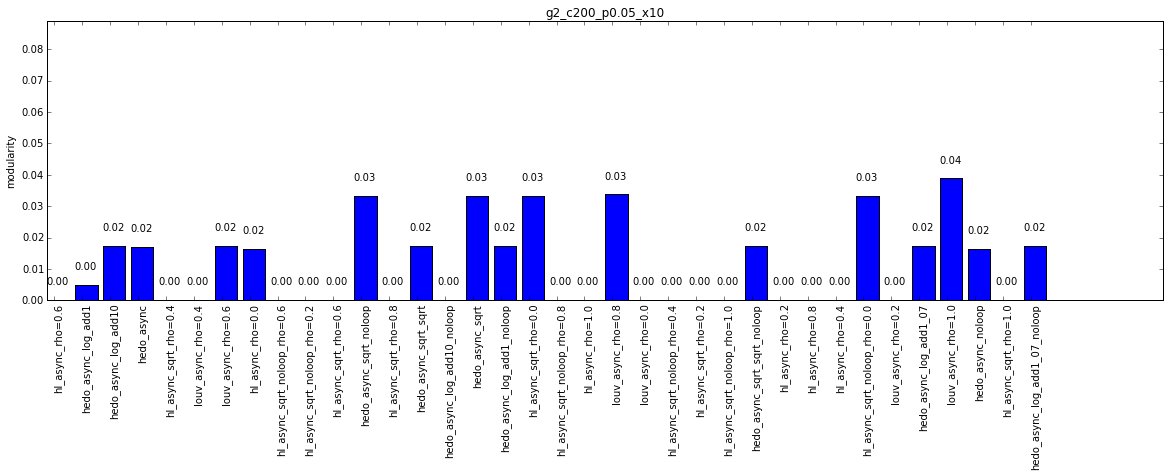

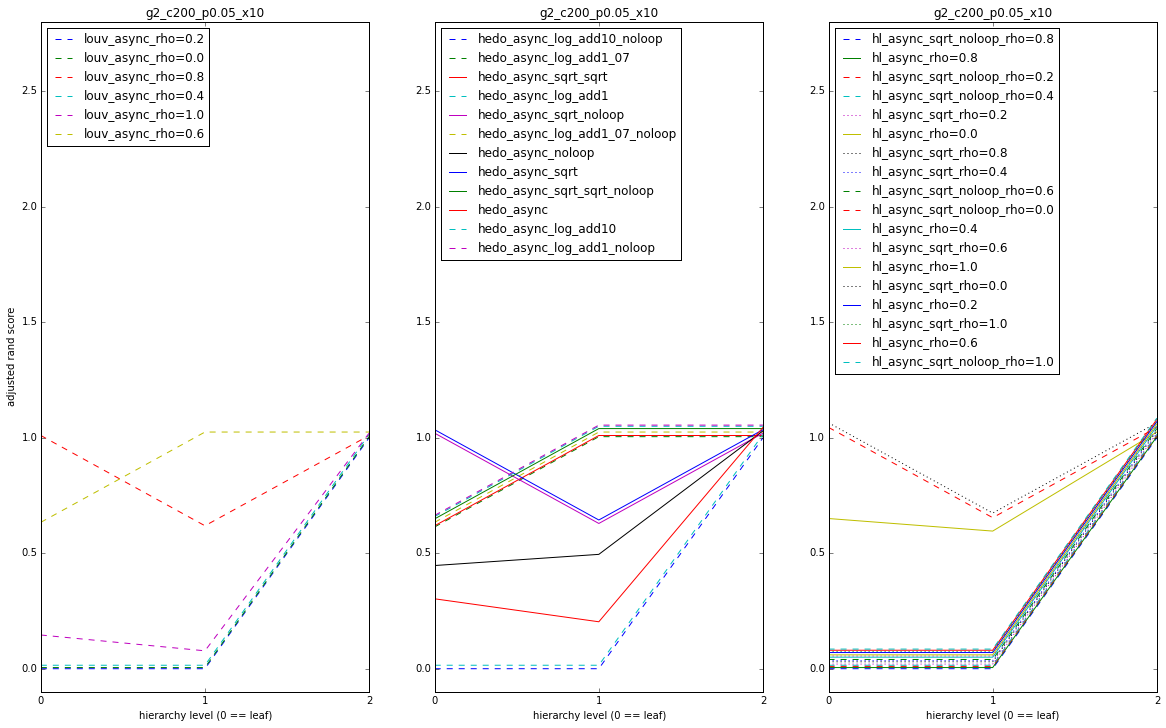

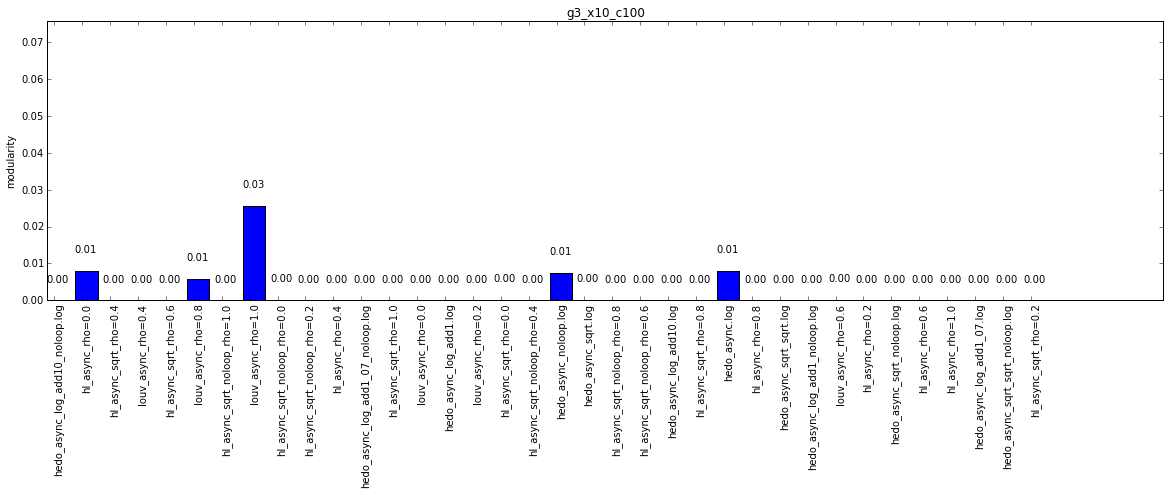

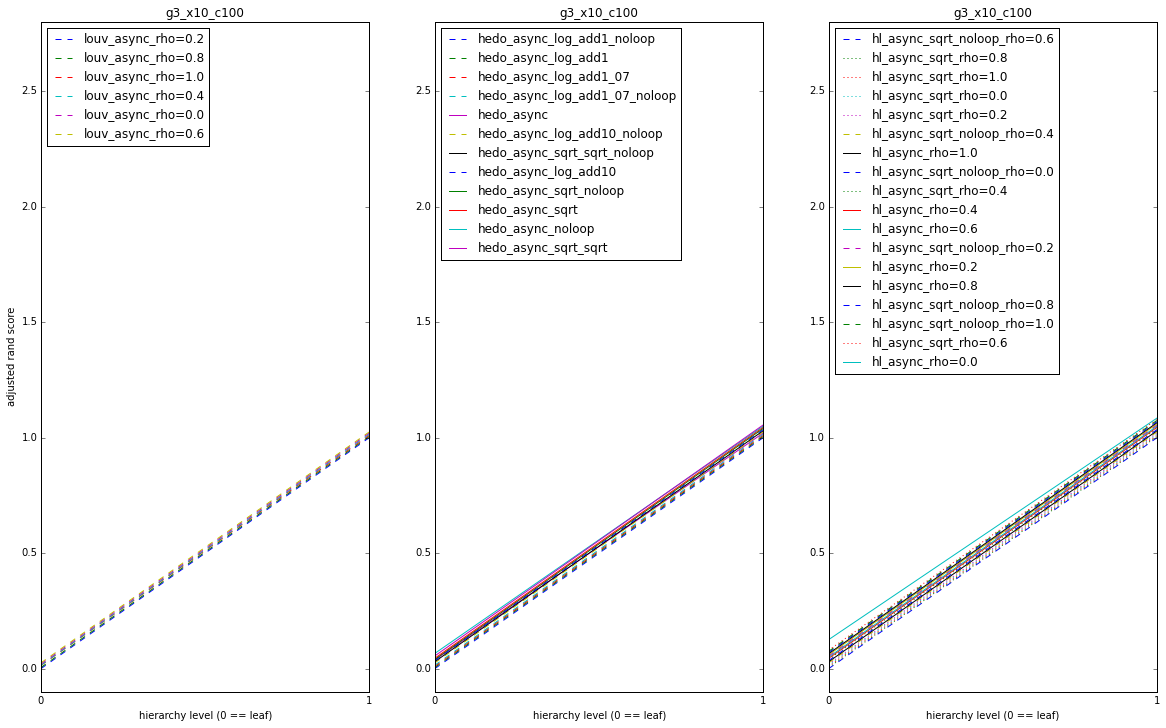

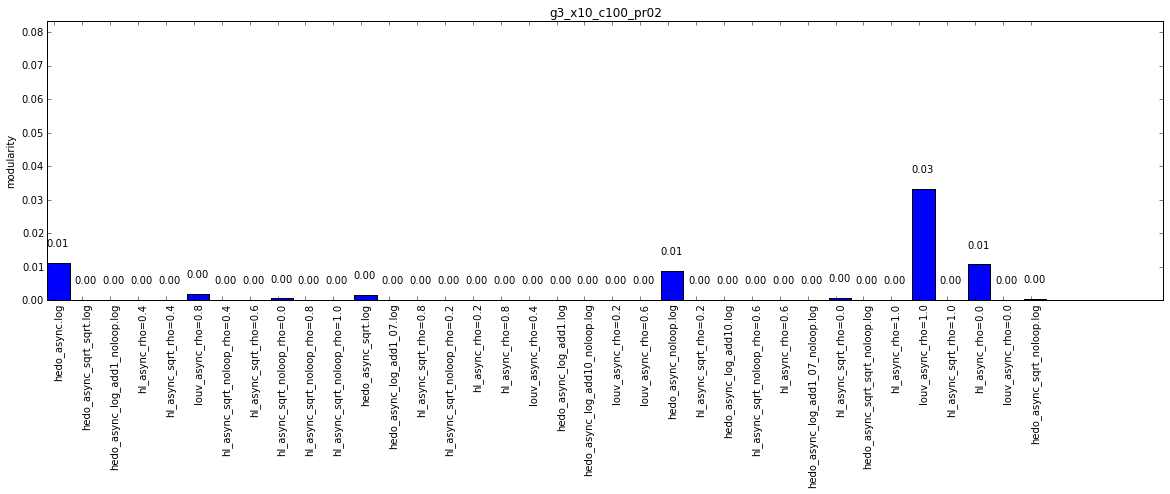

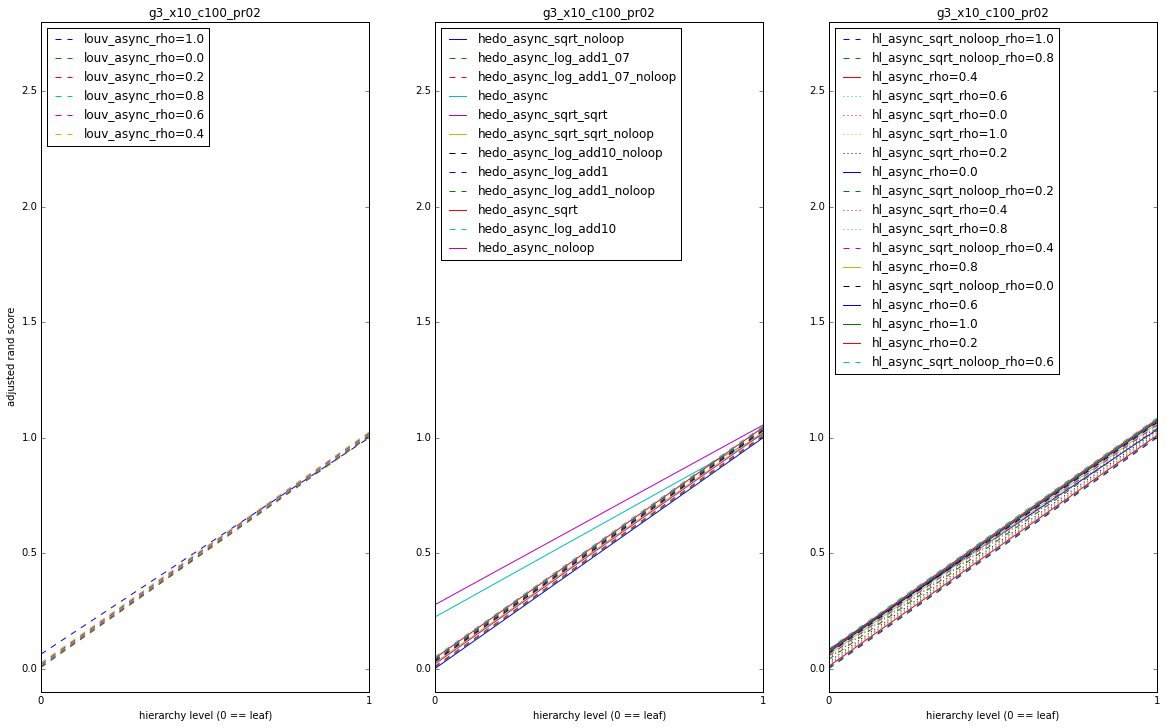

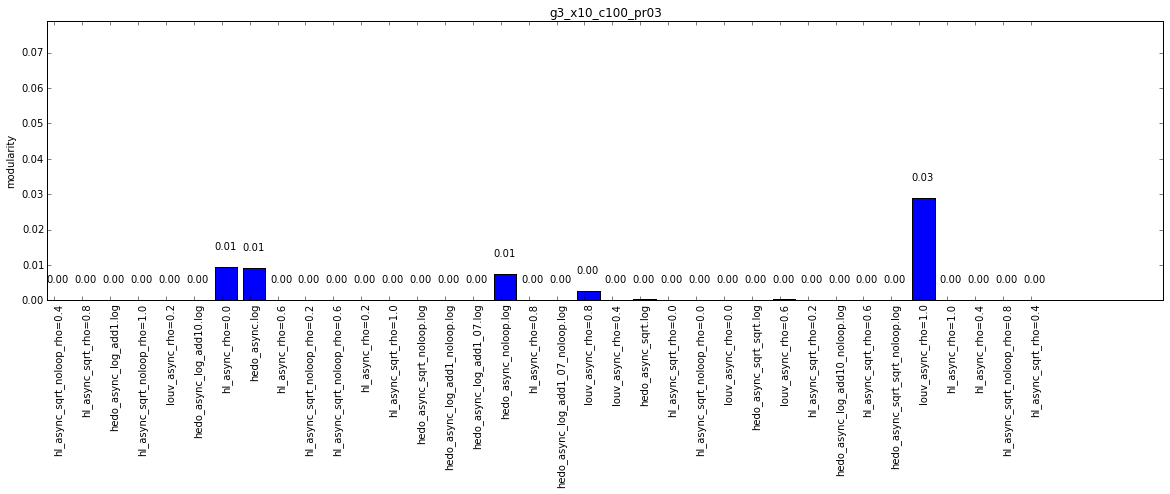

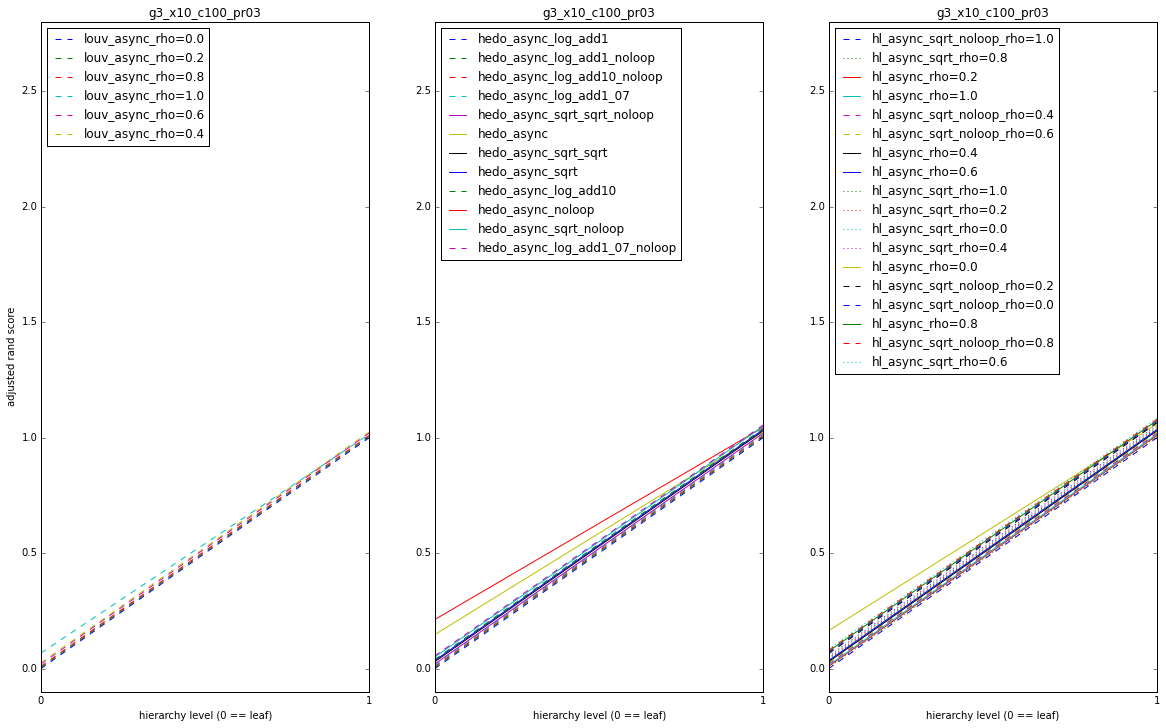

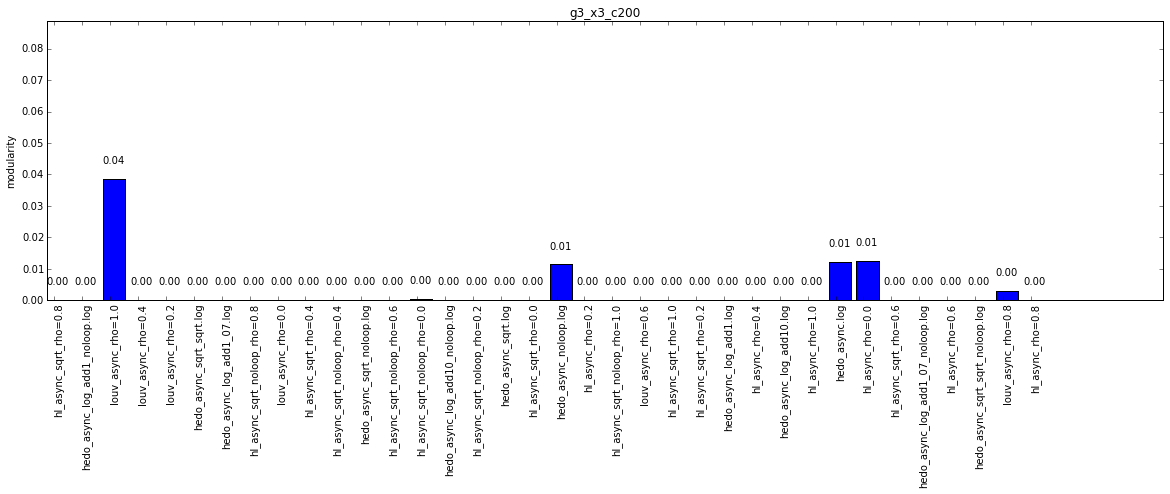

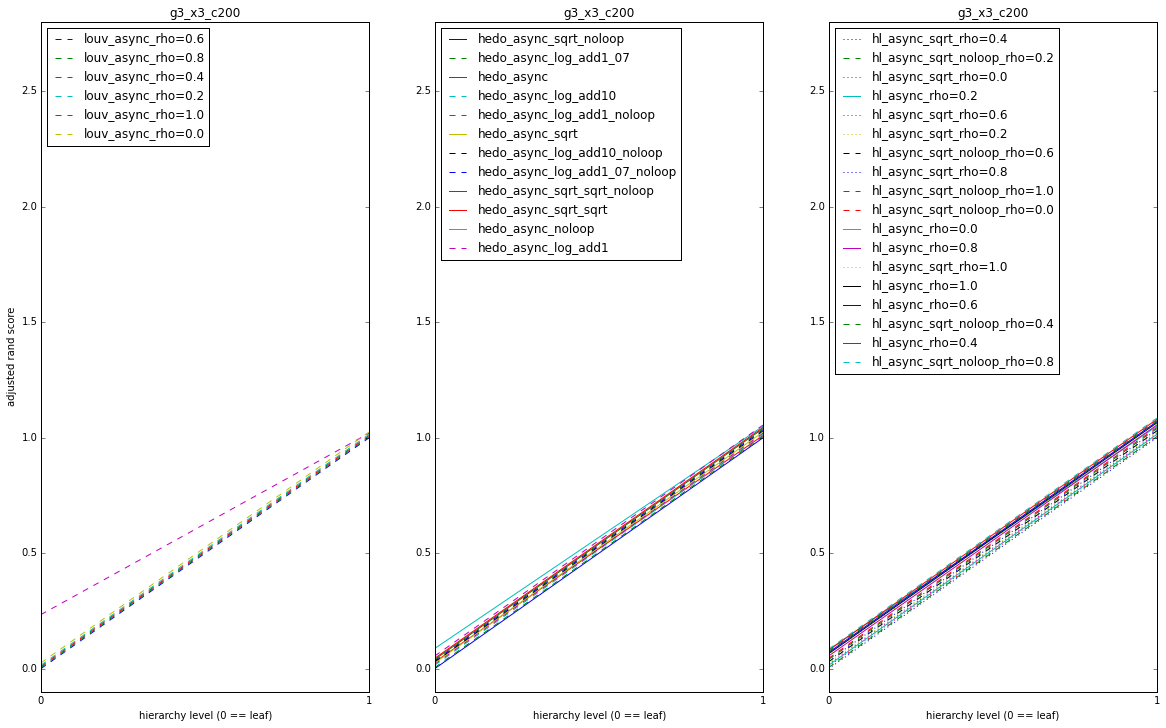

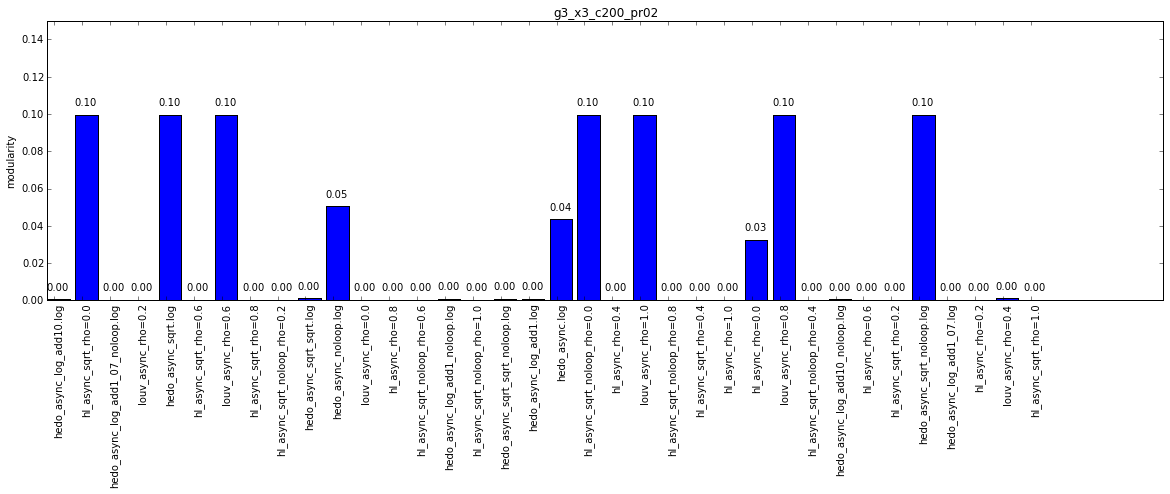

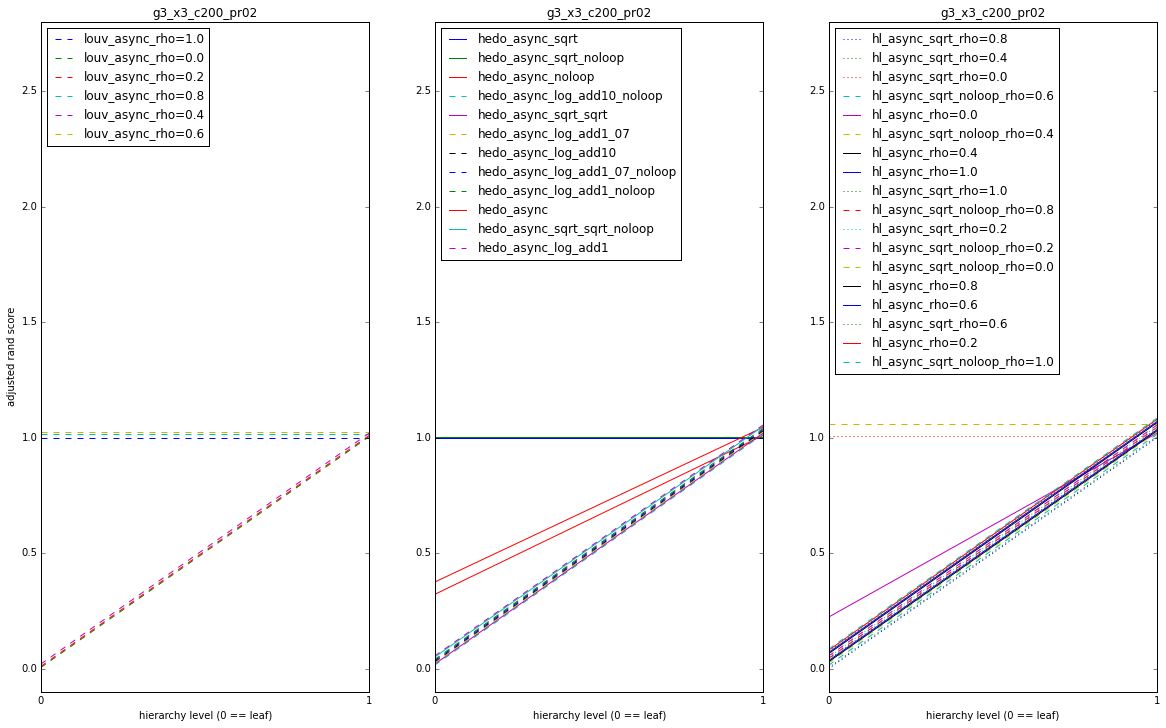

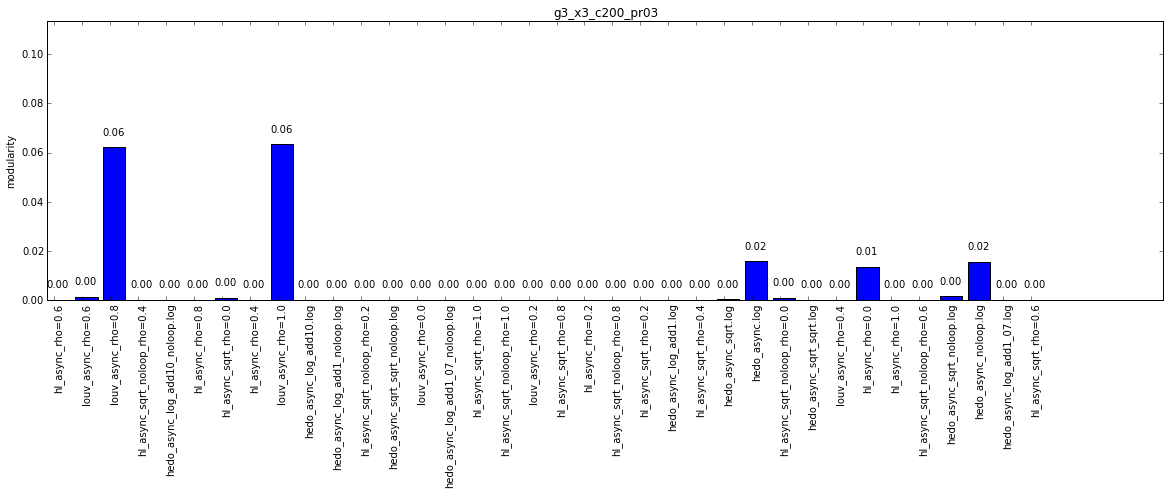

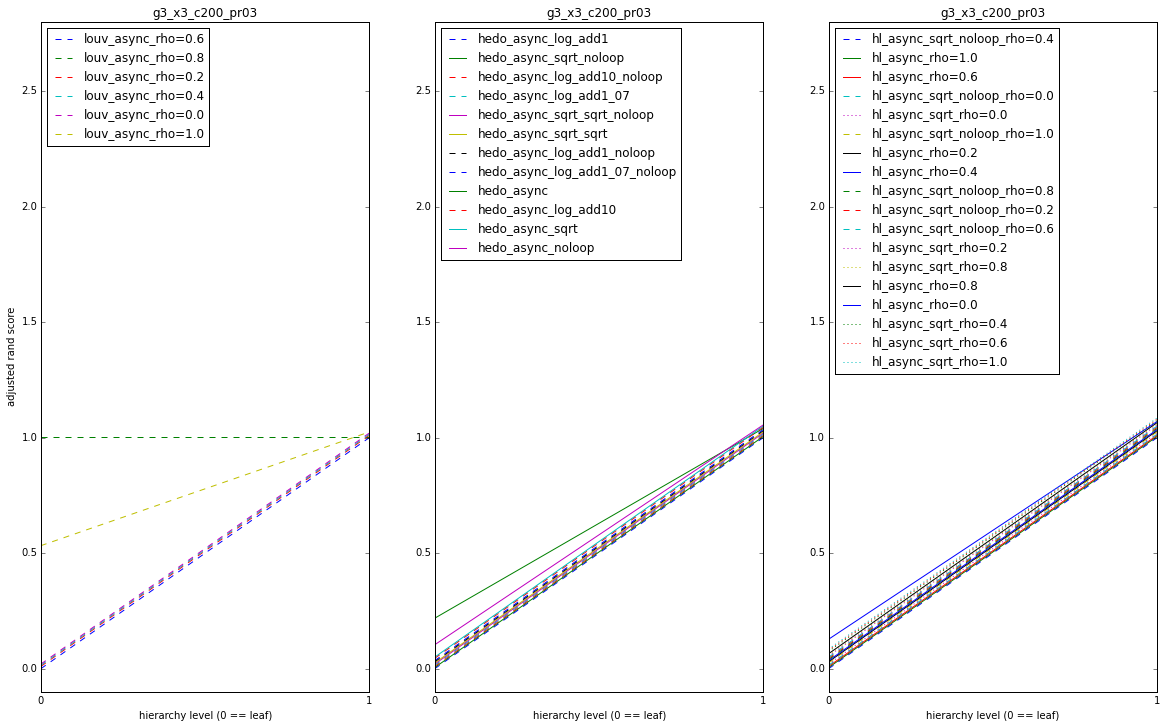

In [35]:
for idx,g in enumerate(sorted(graphs)):    
    fig = plt.figure(figsize=(20, 5))

    exp_name = g.split('/')[-1].replace('.bin', '')
    values = []
    algs = []
    for log_fpath in glob.glob(g + '*.log'):
        alg_name = '.'.join(log_fpath.split('.')[4:7]).replace('.clusts', '').replace('bin.', '')
        algs.append(alg_name)
        values.append(get_peak_modularity(log_fpath))

    ax = fig.add_subplot(1, 1, 1)
    ax.bar(range(len(values)), values)
    ax.set_xticks(np.arange(len(values)) + 0.25)
    ax.set_xticklabels(algs)
    ax.set_ylim([0, max(values)+0.05])
    setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor");
    title(exp_name);
    ylabel('modularity');
    for i, v in enumerate(values):
        ax.text(i, v+0.005, '{:.2f}'.format(v))
    
    gtruth = load_clusterings(g + ".labels")
    algs = []
    values = []
    for cl_fpath in glob.glob(g + "*.clusts"):
        alg_name = '.'.join(cl_fpath.split('.')[4:8]).replace('.clusts', '').replace('bin.', '')
        clusts = load_clusterings(cl_fpath)
        algs.append(alg_name)
        values.append(np.asarray(score_clustering_best_match(clusts, gtruth)))
    
    fig = plt.figure(figsize=(20, 12))
    i = 0
    for fun, line_style in [(lambda n: 'louv' in n, '--'),
                            (lambda n: 'hedo' in n, '-'),
                            (lambda n: 'hl' in n, '-'),
                           ]:

        ax = fig.add_subplot(1, 3, 1 + i)
        j = 0
        for n,v in zip(algs, values):
            ls = line_style
            if 'hl_async_sqrt_noloop' in n:
                ls = '--'
            if 'hedo_async_log' in n:
                ls = '--'
            if 'hl_async_sqrt_rho' in n:
                ls = ':'
            if fun(n):
                ax.plot(np.arange(len(v)), v + j*0.005, ls, label=n)
                j += 1
        title(exp_name);
        xlabel('hierarchy level (0 == leaf)')
        ax.set_xticks(range(max([len(v) for v in values])))
        if i == 0:
            ylabel('adjusted rand score')
        ax.set_ylim([-0.1, 2.8])
        legend(loc='upper left');
        i += 1